<a href="https://colab.research.google.com/github/JoshRome/ai_course/blob/master/HW4/HW4_3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning MobileNet pt2



This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the MobileNet model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [69]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-20 18:57:34--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   114MB/s    in 0.6s    

2020-04-20 18:57:35 (114 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with MobileNet convolution base and custom densely connected layers

### Load the convolutional base

In [72]:
from keras.applications import MobileNet

conv_base = MobileNet(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [73]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 151, 151, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 75, 75, 32) 

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [76]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
flatten_7 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               8389120   
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                

## Train the model end to end with frozen convolutional base

In [81]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 19s 190ms/step - loss: 0.1709 - acc: 0.9355 - val_loss: 0.2332 - val_acc: 0.9560
Epoch 2/100
100/100 [==============================] - 16s 163ms/step - loss: 0.1631 - acc: 0.9405 - val_loss: 0.1083 - val_acc: 0.9630
Epoch 3/100
100/100 [==============================] - 16s 163ms/step - loss: 0.1582 - acc: 0.9440 - val_loss: 0.1259 - val_acc: 0.9400
Epoch 4/100
100/100 [==============================] - 16s 163ms/step - loss: 0.1517 - acc: 0.9430 - val_loss: 0.1365 - val_acc: 0.9600
Epoch 5/100
100/100 [==============================] - 16s 164ms/step - loss: 0.1616 - acc: 0.9410 - val_loss: 0.0678 - val_acc: 0.9600
Epoch 6/100
100/100 [==============================] - 16s 162ms/step - loss: 0.1377 - acc: 0.9430 - val_loss: 0.2040 - val_acc: 0.9640
Epoch 7/100
100/100 [==============================] - 16s 162ms/step - loss: 0.1451 - acc: 0.9445 -

## Display curves of loss and accuracy during training

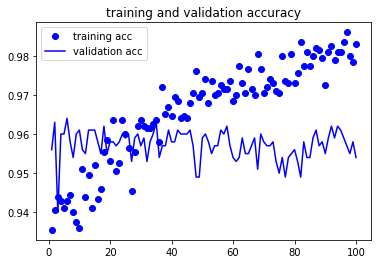

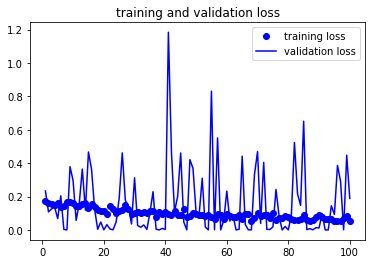

In [82]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv_pw_12':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [84]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 19s 189ms/step - loss: 0.0536 - acc: 0.9795 - val_loss: 0.0397 - val_acc: 0.9530
Epoch 2/100
100/100 [==============================] - 16s 160ms/step - loss: 0.0349 - acc: 0.9885 - val_loss: 0.2907 - val_acc: 0.9540
Epoch 3/100
100/100 [==============================] - 16s 161ms/step - loss: 0.0760 - acc: 0.9760 - val_loss: 0.1850 - val_acc: 0.9550
Epoch 4/100
100/100 [==============================] - 16s 161ms/step - loss: 0.0597 - acc: 0.9815 - val_loss: 0.5092 - val_acc: 0.9560
Epoch 5/100
100/100 [==============================] - 16s 163ms/step - loss: 0.0478 - acc: 0.9845 - val_loss: 8.2557e-06 - val_acc: 0.9570
Epoch 6/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0713 - acc: 0.9775 - val_loss: 0.1578 - val_acc: 0.9600
Epoch 7/100
100/100 [==============================] - 16s 161ms/step - loss: 0.0523 - acc: 0.9850 - val_loss: 0.0021 - val_acc: 0.9580
Epoch 8/100
100/100 [=======================

## Display learning curves during fine-tuning

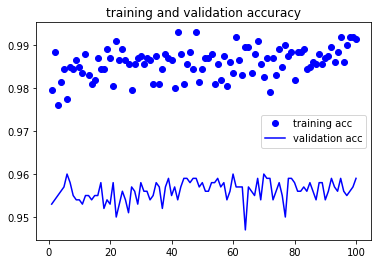

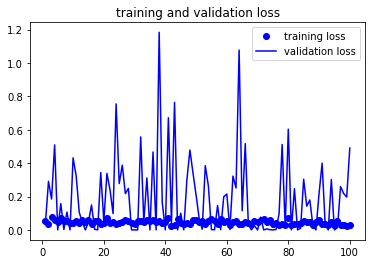

In [85]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. I should try  adding dropout for the densely connected layer.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [87]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.4903033375740051
Validation accuracy: 0.9589999914169312
